<a href="https://colab.research.google.com/github/Saifweb/P2M-Sarra-Saif/blob/main/P2M_1_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importation

In [1]:
!pip install keras_preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly 
import plotly.graph_objects as go
import numpy as np
from keras.layers import LSTM
from keras.layers import Dense
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error
from keras.layers import LSTM, Dropout, Dense
from sklearn.preprocessing import MinMaxScaler
import itertools
from keras.callbacks import ModelCheckpoint, EarlyStopping
from IPython.display import display
from keras.models import Sequential
import tensorflow as tf
from copy import copy

#data visualisation

In [8]:
def plot_sequence_lengths(data, title, ax):
    # Calculate the lengths of sequences
    sequence_lengths = data['sequence'].apply(lambda x: len(x))

    # Get unique sequence lengths and their frequencies
    unique_lengths, frequencies = sequence_lengths.value_counts().sort_index().index, sequence_lengths.value_counts().sort_index().values

    # Plot the sequence lengths
    ax.plot(unique_lengths, frequencies, marker='o', linestyle='-')
    ax.set_xlabel('Sequence Length')
    ax.set_ylabel('Frequency')
    ax.set_title(title)

In [ ]:
hello = pd.read_csv("Hello.csv", index_col='TIME')
hello1 = transform_dataset(hello,"hello")
please = pd.read_csv("please.csv", index_col='TIME')
please1 = transform_dataset(please,"please")
thankYou = pd.read_csv("ThankYou.csv", index_col='TIME')
thankYou1= transform_dataset(thankYou,"thankyou")
YouWelcome = pd.read_csv("YouWelcome.csv", index_col='TIME')
youWelcome1 = transform_dataset(YouWelcome,"welcome")

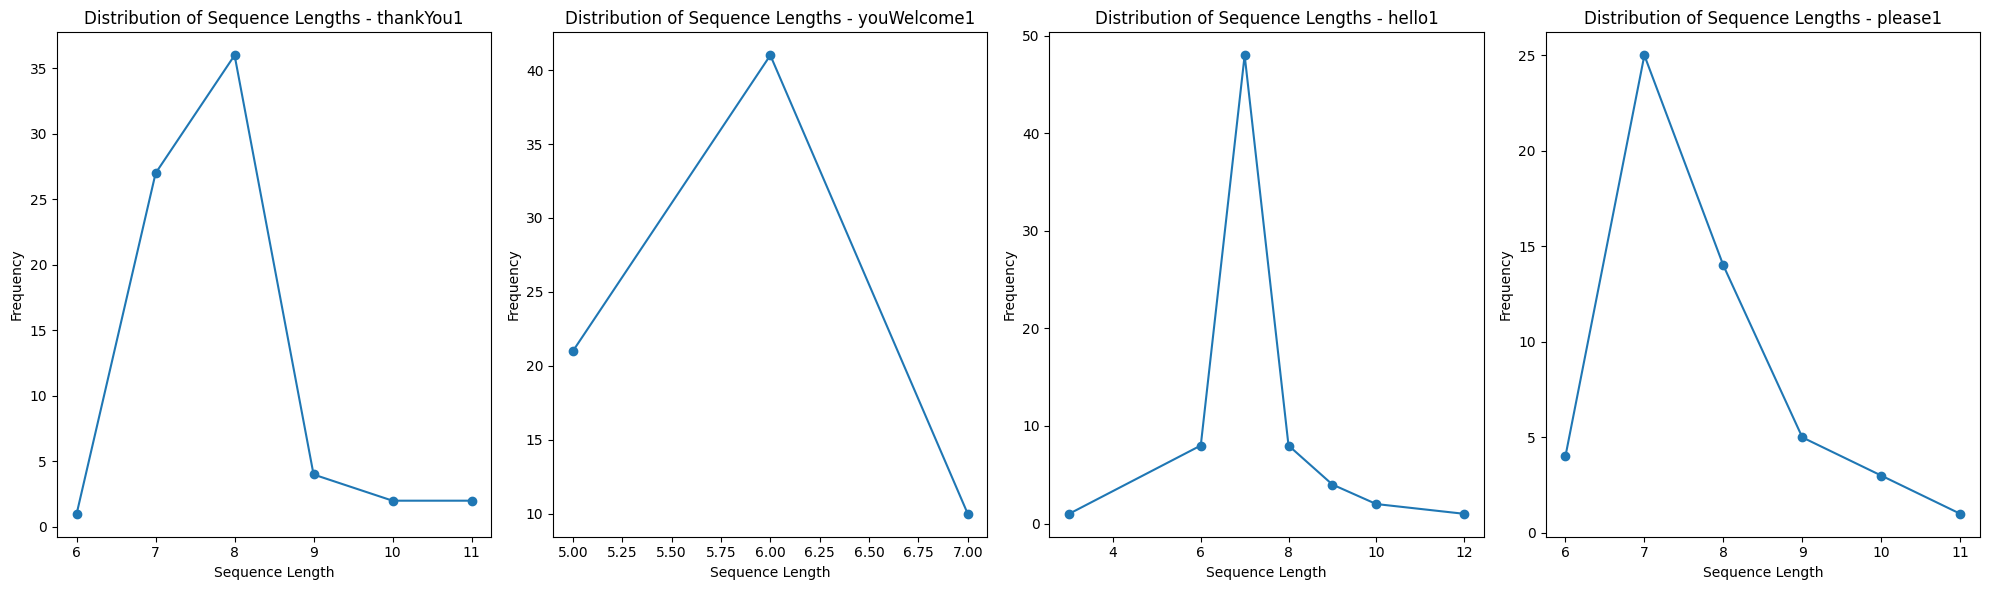

In [ ]:
# Create a row with four subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 6))

# Plot for thankYou1
plot_sequence_lengths(thankYou1, 'Distribution of Sequence Lengths - thankYou1', axs[0])

# Plot for youWelcome1
plot_sequence_lengths(youWelcome1, 'Distribution of Sequence Lengths - youWelcome1', axs[1])

# Plot for hello1
plot_sequence_lengths(hello1, 'Distribution of Sequence Lengths - hello1', axs[2])

# Plot for please1
plot_sequence_lengths(please1, 'Distribution of Sequence Lengths - please1', axs[3])

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots in the same row
plt.show()

#Transform Data

In [3]:
def transform_dataset(df,label):
  dataset = pd.DataFrame(columns=['sequence', 'label'])
  seq=[]
  for index, row in df.iterrows():
    L=list(row)
    if (L==[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]):
      if(seq!=[]):
        dataset = dataset.append({'sequence': seq, 'label': label}, ignore_index=True)
      seq=[]
    else :
      seq.append(L)
  return(dataset)

In [4]:
def padding(l,maxlen):
  l1=copy(l)
  for i in range(maxlen-len(l)):
    l1.append([0.0] *len(l[0]))
  return l1

In [79]:
def CleanData(filename, word, max_length):
    dataset = pd.read_csv(filename, index_col='TIME')
    dataset.dropna(inplace=True)
    dataset.reset_index(drop=True, inplace=True)
    # Remove columns that we don't need
    dataset = dataset.loc[:, 'CH1':'CH6']
    
    data = transform_dataset(dataset, word)
    
    # Filter rows based on sequence length condition
    data_filtered = data[
        (data['sequence'].apply(lambda x: len(x)) >= 5) &
        (data['sequence'].apply(lambda x: len(x)) <= 9)
    ]
    
    # Truncate sequences with length > max_length
    data_filtered['sequence'] = data_filtered['sequence'].apply(lambda x: x[:max_length] if len(x) > max_length else x)
    
    # Add padding if sequence < max_length
    data_filtered['sequence'] = data_filtered['sequence'].apply(lambda x: padding(x, max_length) if len(x) < max_length else x)
    
    return data_filtered

In [ ]:
#Clean Data:
data_please=CleanData('please.csv','please',7)
data_thank=CleanData('ThankYou.csv','thankyou',7)
data_welcome=CleanData('YouWelcome.csv','welcome',7)
data_hello=CleanData('Hello.csv','hello',7)

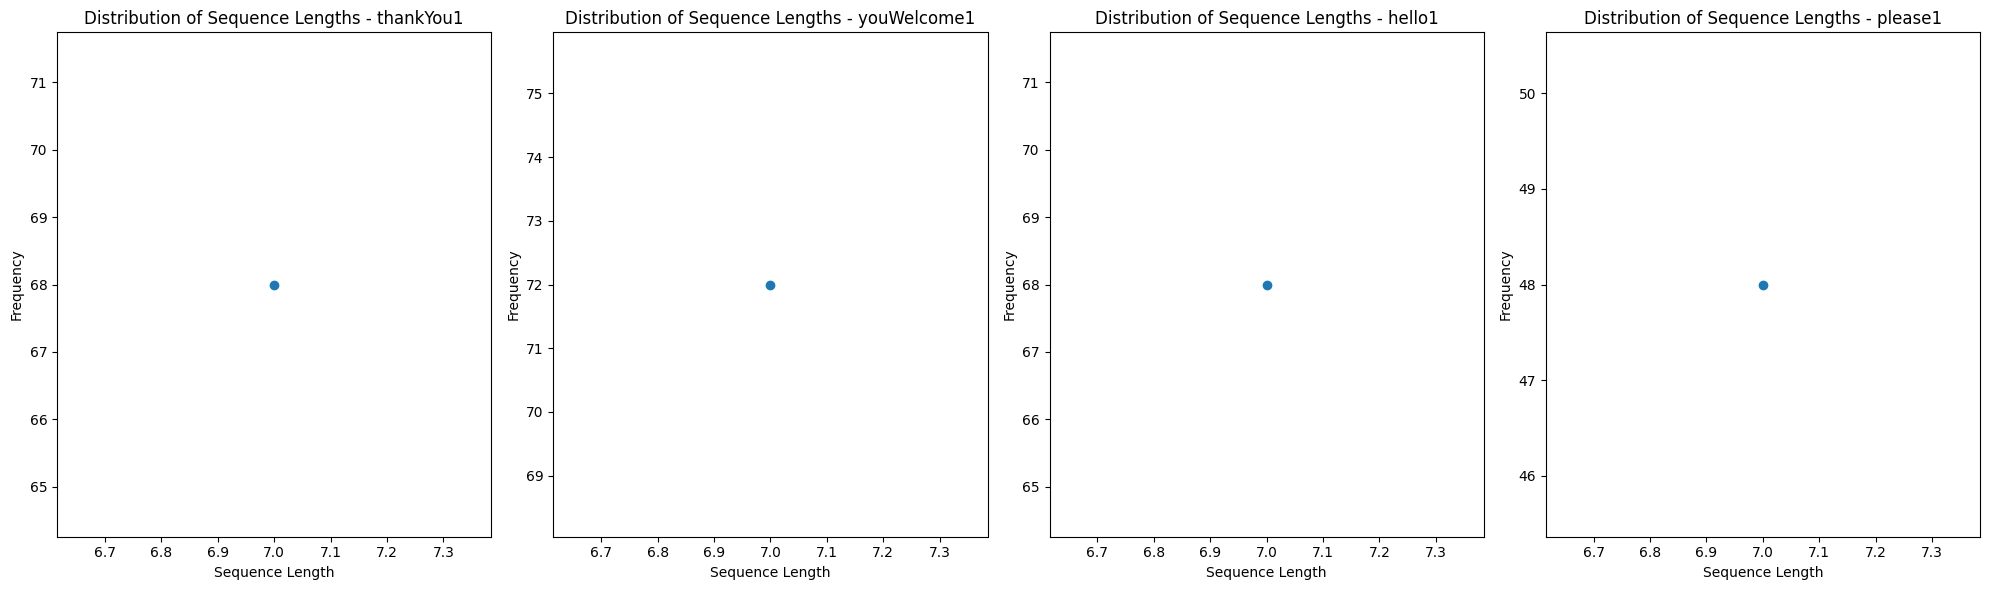

In [81]:
# Create a row with four subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 6))

# Plot for thankYou1
plot_sequence_lengths(data_thank, 'Distribution of Sequence Lengths - thankYou1', axs[0])

# Plot for youWelcome1
plot_sequence_lengths(data_welcome, 'Distribution of Sequence Lengths - youWelcome1', axs[1])

# Plot for hello1
plot_sequence_lengths(data_hello, 'Distribution of Sequence Lengths - hello1', axs[2])

# Plot for please1
plot_sequence_lengths(data_please, 'Distribution of Sequence Lengths - please1', axs[3])

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots in the same row
plt.show()

In [82]:
#check length for each one
print('for please',len(data_please))
print('for hello',len(data_hello))
print('for thankyou',len(data_thank))
print('for youwelcome',len(data_welcome))

for please 48
for hello 68
for thankyou 68
for youwelcome 72


##Combine All datasets into one dataset

In [83]:
# Concatenate the datasets
data = pd.concat([data_please, data_hello,data_thank,data_welcome], ignore_index=True)

In [84]:
len(data)

256

In [85]:
data.label.value_counts()

welcome     72
hello       68
thankyou    68
please      48
Name: label, dtype: int64

In [86]:
dataset = data.sample(frac=1).reset_index(drop=True)
dataset.head(15)

,sequence,label
0,"[[-3.13, -7.75, 3.21, -0.24, -0.07, 0.01], [-3...",welcome
1,"[[2.25, -8.81, 1.78, 0.38, -1.59, -0.84], [5.3...",hello
2,"[[2.93, -1.21, -10.76, -0.1, 0.03, -0.22], [4....",thankyou
3,"[[-1.88, -7.49, 4.33, -0.32, 0.11, 0.03], [-1....",welcome
4,"[[-2.16, -7.32, 5.54, -0.19, 0.21, 0.12], [-3....",welcome
5,"[[-2.49, -7.13, 5.06, -0.27, 0.04, -0.06], [-2...",welcome
6,"[[-2.54, -8.33, 3.52, -0.06, 0.13, -0.02], [-2...",welcome
7,"[[4.63, -7.27, 5.05, 0.37, 0.29, 0.14], [7.38,...",hello
8,"[[1.95, -9.13, 3.61, 0.09, 0.56, 0.14], [4.05,...",hello
9,"[[-1.68, -8.21, 4.48, -0.07, 0.11, -0.06], [-2...",welcome


In [87]:
len(dataset)

256

In [88]:
dataset['sequence'][0]

[[-3.13, -7.75, 3.21, -0.24, -0.07, 0.01],
 [-3.44, -8.09, 4.57, -0.29, 0.36, 0.05],
 [-2.72, -7.51, 4.05, 0.18, 0.18, 0.28],
 [-1.1, -8.15, 3.79, -0.49, 0.43, 1.21],
 [3.63, -4.55, 6.48, -1.31, 0.14, 0.94],
 [5.98, 1.03, 9.07, -0.77, 0.31, 0.22],
 [7.08, -0.66, 9.46, 0.31, 0.14, 0.1]]

In [89]:
from sklearn.model_selection import train_test_split
# train_test split
train,test= train_test_split(dataset, random_state=19, test_size=0.2)

In [90]:
test

,sequence,label
246,"[[-2.74, -8.42, 3.17, -0.03, -0.08, -0.04], [-...",welcome
115,"[[11.43, 0.63, 0.58, -0.11, 1.53, -0.11], [8.8...",please
164,"[[9.17, -1.03, 1.64, 0.07, -0.01, -0.03], [10....",please
205,"[[3.03, -8.45, 3.91, 0.23, -0.26, 0.13], [6.1,...",hello
202,"[[-1.37, -8.25, 4.36, 0.37, -0.28, -0.04], [-1...",welcome
233,"[[5.35, -7.36, 4.27, 0.17, 0.18, 0.05], [5.47,...",hello
119,"[[-1.11, -7.54, 5.69, -0.11, 0.09, -0.01], [-1...",welcome
96,"[[4.36, -0.35, -9.28, -0.09, 0.05, -0.06], [3....",thankyou
222,"[[-2.36, -8.25, 4.25, -0.18, 0.7, 0.05], [-2.2...",welcome
72,"[[4.57, -1.52, -9.98, -0.67, 0.02, -0.28], [6....",thankyou


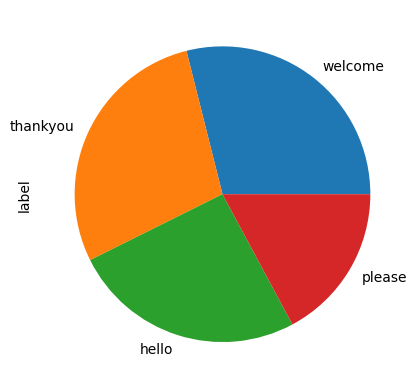

In [91]:
train.label.value_counts(normalize=True).plot.pie()
plt.show()

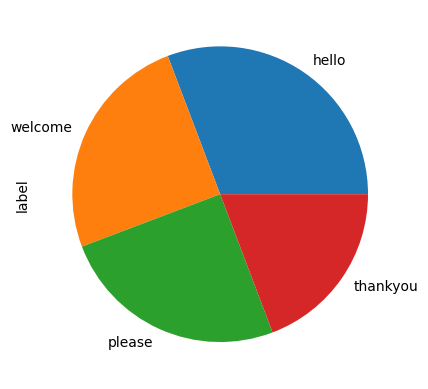

In [92]:
test.label.value_counts(normalize=True).plot.pie()
plt.show()

#Model

In [93]:
#first lets make a copy for our data ( just for security)
df=train.copy()
df_test=test.copy()

In [94]:
print(len(df))

204


In [95]:
# Splitting the DataFrame into features (X) and target (y)
X = np.stack(df['sequence'].values)
y = df['label'].values
x_test=np.stack(df_test['sequence'].values)
y_test = df_test['label'].values

In [96]:
df.iloc[5][1]

'welcome'

In [97]:
y[5]

'welcome'

In [ ]:
y

In [ ]:
print(y)

In [100]:
len(y)

204

In [101]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
# Encoding the target variables
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y)
y_test= le.fit_transform(y_test)
y_test = to_categorical(y_test)

In [102]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(4, activation='softmax'))


In [103]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [104]:
# Fit the model
model.fit(X,y, epochs=200, verbose=0)

#Results 

In [109]:
yhat_test=model.predict(x_test)

2/2 [==============================] - 0s 8ms/step


In [133]:
list_of_cat=['hello','please','thankyou','welcome']

In [111]:
df_test['label'][:10]

246     welcome
115      please
164      please
205       hello
202     welcome
233       hello
119     welcome
96     thankyou
222     welcome
72     thankyou
Name: label, dtype: object

In [ ]:
predicted_labels=[]
actual_labels=list(df_test['label'].values)
accuracy=0
for i in np.argmax(yhat_test,axis=1):
  predicted_labels.append(list_of_cat[i])
  print(list_of_cat[i])

In [135]:
#Accuracy!
for i in range(len(predicted_labels)):
  if (predicted_labels[i]==actual_labels[i]):
    accuracy+=1
  else:
    print(predicted_labels[i],actual_labels[i])
accuracy=accuracy/len(predicted_labels)

hello please


In [136]:
accuracy

0.9807692307692307